# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [2.1 Tokenisation](#PREPROCESS_tokenized)
    * [2.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [2.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [2.4 Comparaison des scores](#PREPROCESS_scores)
* [3. Recherche du `plongement` le plus adapté](#EMBEDDING)
    * [3.1 Word2Vec](#EMBEDDING_Word2Vec)
    * [3.2 FastText](#EMBEDDING_FastText)
    * [3.3 Comparaison des scores](#EMBEDDING_scores)
* [4. Recherche du `modèle` de classification le plus adapté](#CLF)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
keras.utils.set_random_seed(random_seed)

2022-07-29 01:51:53.234400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 01:51:53.234424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [3]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN.csv")

#### Définissons les fonctions génériques de notre Spot Checking 

In [5]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [2]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [6]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=6,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

#### Définissons nos fonctions de perte, d'optimisation et les métriques à surveiller

In [7]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()

#### Définissons une méthode de `cross-validation`

In [4]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

---
---
# 2. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [8]:
def architecture1(f_opti, f_loss, f_metrics, embedding):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

---
## 2.1 Jeu de données BRUT (RAW) <a class="anchor" id="PREPROCESS_tokenized"></a> [⇪](#menu)

### Chargeons le jeu de données brut (RAW) pour nos premiers essais

In [9]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [10]:
sample_size = 100000
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [11]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1303215,"[@RichGolisch, Thanks!]",1
1121114,"[Trying, to, get, a, babysitter, and, be, 999,...",1


(100000, 2)

In [12]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_raw'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [13]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=2000, padding_size=35, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}")
        print(f">> X_train_enc: {X_train_enc[:1]}")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

In [14]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ["same here. i know how it sucks that people actually don't appreciate your service is not an easy one"]
>> X_train_enc: [[248, 544, 1, 67, 70, 11, 352, 16, 144, 290, 49, 1105, 38, 1182, 8, 24, 78, 921, 66]]
>> X_train_ready: [[ 248  544    1   67   70   11  352   16  144  290   49 1105   38 1182
     8   24   78  921   66    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 129013


### Entrainons notre Neural Network 

In [15]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [16]:
archi01_model_RAW = architecture1(f_opti, f_loss, f_metrics, embedding)

2022-07-29 01:51:59.448666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 01:51:59.448689: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 01:51:59.448707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist
2022-07-29 01:51:59.448883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
archi01_model_RAW.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         33027328  
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         229504    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [18]:
t0 = time.perf_counter()
history_clf_archi01_RAW = archi01_model_RAW.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.7246
Epoch 1: val_accuracy improved from -inf to 0.76140, saving model to models/archi01_RAW.epoch01-accuracy0.76.hdf5
2500/2500 [==============================] - 960s 384ms/step - loss: 0.5388 - accuracy: 0.7246 - val_loss: 0.4970 - val_accuracy: 0.7614 - lr: 5.0000e-04
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.7725
Epoch 2: val_accuracy improved from 0.76140 to 0.76155, saving model to models/archi01_RAW.epoch02-accuracy0.76.hdf5
2500/2500 [==============================] - 973s 389ms/step - loss: 0.4769 - accuracy: 0.7725 - val_loss: 0.4966 - val_accuracy: 0.7616 - lr: 5.0000e-04
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.7886
Epoch 3: val_accuracy did not improve from 0.76155
2500/2500 [==============================] - 979s 392ms/step - loss: 0.4478 - accuracy: 0.7886 - val_loss: 0.4972 - 

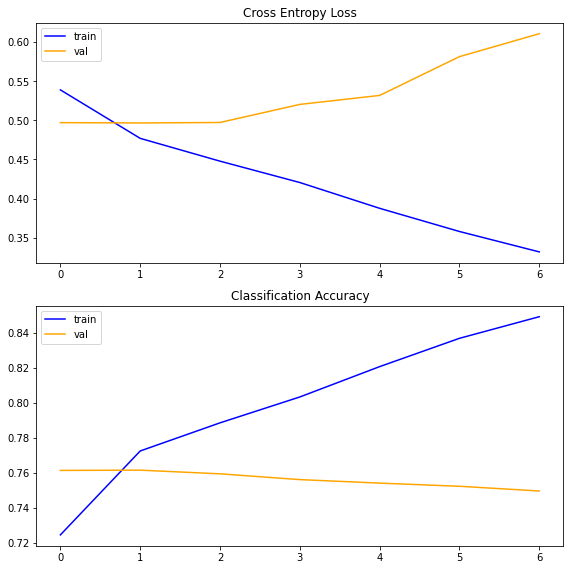

In [19]:
summarize_diagnostics(history_clf_archi01_RAW)

### Affichons les scores du modèle

In [20]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

625/625 [==============================] - 2s 3ms/step


(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + TF-IDF) ----------------------------------------------------------------------

             ROC_AUC : 0.8408
                  F1 : 0.7639
            ACCURACY : 0.7614
           PRECISION : 0.7590
              RECALL : 0.7690
   AVERAGE_PRECISION : 0.8375

       TRAINING-TIME : 6702.1989
      INFERENCE-TIME : 2.0643

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.75      0.76      9958
Prediction = 1       0.76      0.77      0.76     10042

      accuracy                           0.76     20000
     macro avg     

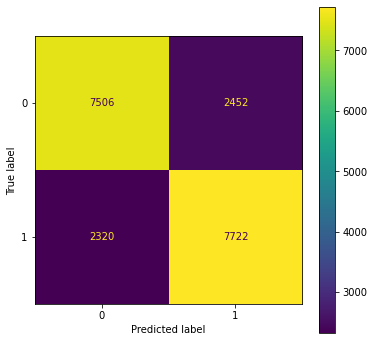

--- ROC AUC ---------------------------------------------------------------------------------------- 



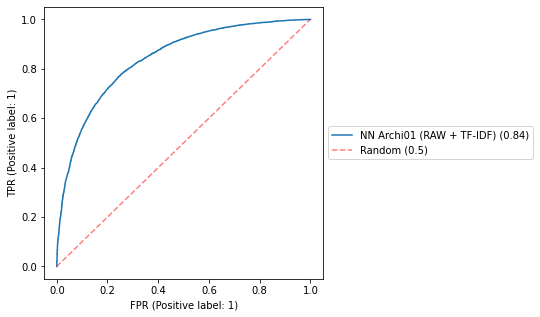

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



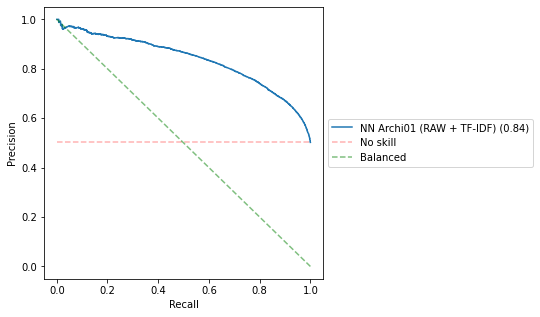

In [21]:
model_name = "NN Archi01 (RAW + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.2 TOKENISATION + FILTRAGE <a class="anchor" id="PREPROCESS_filtered"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré

In [22]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
data_nlp = joblib.load(data_nlp_path)

In [23]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [24]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_filtered,target
33683,"[wretched, weather, note, washed, car]",0
1346934,"[congrats, man, looks, like, fierce, eyes]",1


(100000, 2)

In [25]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_filtered'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [26]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['fucking hero yo']
>> X_train_enc: [[352, 1249, 1570]]
>> X_train_ready: [[ 352 1249 1570    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 36785


### Entrainons notre Neural Network 

In [27]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [28]:
archi01_model_FILTERED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [29]:
archi01_model_FILTERED.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         9416960   
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         229504    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [30]:
t0 = time.perf_counter()
history_clf_archi01_FILTERED = archi01_model_FILTERED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_FILTERED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 0.6298 - accuracy: 0.6214
Epoch 1: val_accuracy improved from -inf to 0.72705, saving model to models/archi01_FILTERED.epoch01-accuracy0.73.hdf5
2500/2500 [==============================] - 280s 112ms/step - loss: 0.6298 - accuracy: 0.6214 - val_loss: 0.5464 - val_accuracy: 0.7271 - lr: 5.0000e-05
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7307
Epoch 2: val_accuracy improved from 0.72705 to 0.73635, saving model to models/archi01_FILTERED.epoch02-accuracy0.74.hdf5
2500/2500 [==============================] - 278s 111ms/step - loss: 0.5409 - accuracy: 0.7307 - val_loss: 0.5327 - val_accuracy: 0.7363 - lr: 5.0000e-05
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7442
Epoch 3: val_accuracy did not improve from 0.73635
2500/2500 [==============================] - 280s 112ms/step - loss: 0.5238 - accuracy: 0.7442 - val_loss:

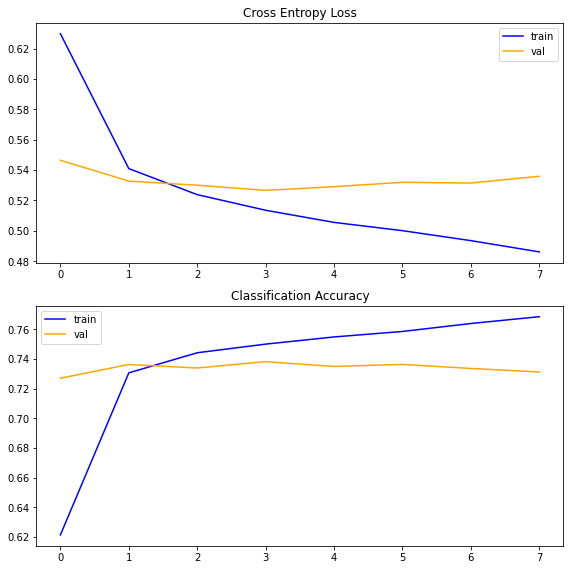

In [31]:
summarize_diagnostics(history_clf_archi01_FILTERED)

### Affichons les scores du modèle

In [32]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_FILTERED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

625/625 [==============================] - 2s 3ms/step


(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (FILTERED + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.8109
                  F1 : 0.7332
            ACCURACY : 0.7363
           PRECISION : 0.7354
              RECALL : 0.7310
   AVERAGE_PRECISION : 0.7978

       TRAINING-TIME : 2270.1218
      INFERENCE-TIME : 2.1400

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.74      0.74     10088
Prediction = 1       0.74      0.73      0.73      9912

      accuracy                           0.74     20000
     macro avg     

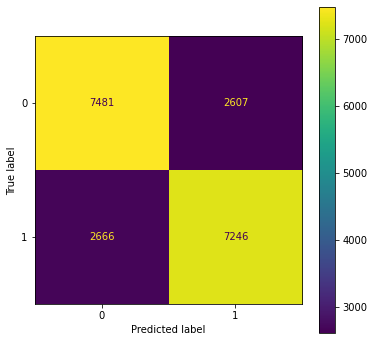

--- ROC AUC ---------------------------------------------------------------------------------------- 



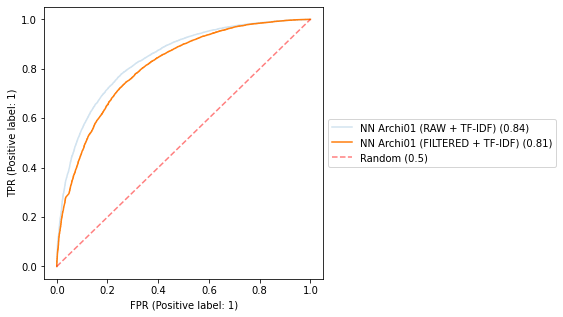

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



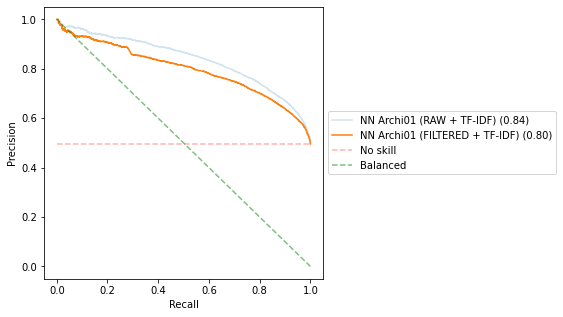

In [33]:
model_name = "NN Archi01 (FILTERED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.3 TOKENISATION + FILTRAGE + LEMMATIZATION <a class="anchor" id="PREPROCESS_lemmatized"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré & lemmatisé

In [34]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp = joblib.load(data_nlp_path)

In [35]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [36]:
display(data_nlp.head(2), data_nlp.shape)

,lemmas,target
33683,"[wretched, weather, note, wash, car]",0
1346934,"[congrat, man, look, like, fierce, eye]",1


(100000, 2)

In [37]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['lemmas'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [38]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['fucking hero yo']
>> X_train_enc: [[577, 794, 1411]]
>> X_train_ready: [[ 577  794 1411    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 31013


### Entrainons notre Neural Network 

In [39]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [40]:
archi01_model_LEMMATIZED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [41]:
archi01_model_LEMMATIZED.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         7939328   
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         229504    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [42]:
t0 = time.perf_counter()
history_clf_archi01_LEMMATIZED = archi01_model_LEMMATIZED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_LEMMATIZED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6215
Epoch 1: val_accuracy improved from -inf to 0.72380, saving model to models/archi01_LEMMATIZED.epoch01-accuracy0.72.hdf5
2500/2500 [==============================] - 179s 72ms/step - loss: 0.6303 - accuracy: 0.6215 - val_loss: 0.5461 - val_accuracy: 0.7238 - lr: 5.0000e-05
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5372 - accuracy: 0.7329
Epoch 2: val_accuracy improved from 0.72380 to 0.73180, saving model to models/archi01_LEMMATIZED.epoch02-accuracy0.73.hdf5
2500/2500 [==============================] - 175s 70ms/step - loss: 0.5372 - accuracy: 0.7329 - val_loss: 0.5322 - val_accuracy: 0.7318 - lr: 5.0000e-05
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.7439
Epoch 3: val_accuracy improved from 0.73180 to 0.73275, saving model to models/archi01_LEMMATIZED.epoch03-accuracy0.73.hdf5
2500/2500 [====================

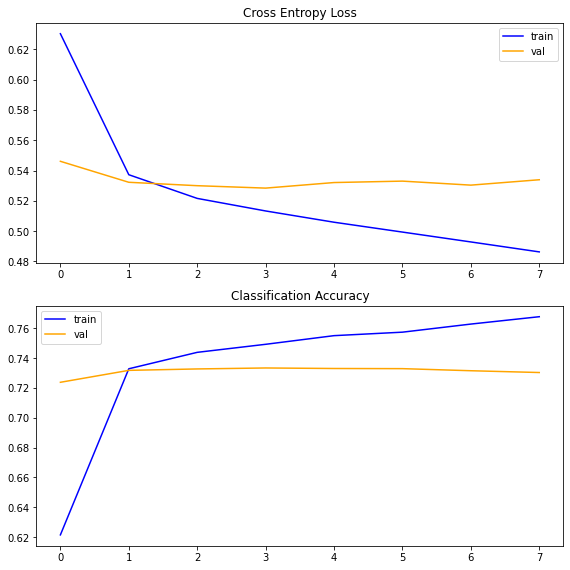

In [43]:
summarize_diagnostics(history_clf_archi01_LEMMATIZED)

### Affichons les scores du modèle

In [44]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_LEMMATIZED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

625/625 [==============================] - 2s 3ms/step


(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (LEMMATIZED + TF-IDF) ---------------------------------------------------------------

             ROC_AUC : 0.8107
                  F1 : 0.7242
            ACCURACY : 0.7318
           PRECISION : 0.7384
              RECALL : 0.7107
   AVERAGE_PRECISION : 0.8008

       TRAINING-TIME : 1410.3410
      INFERENCE-TIME : 2.3023

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.73      0.75      0.74     10088
Prediction = 1       0.74      0.71      0.72      9912

      accuracy                           0.73     20000
     macro avg     

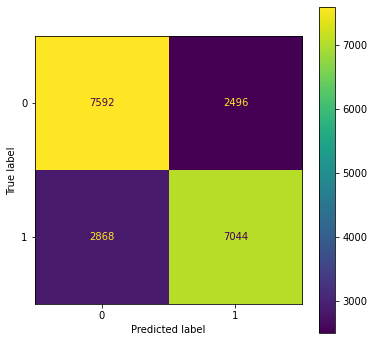

--- ROC AUC ---------------------------------------------------------------------------------------- 



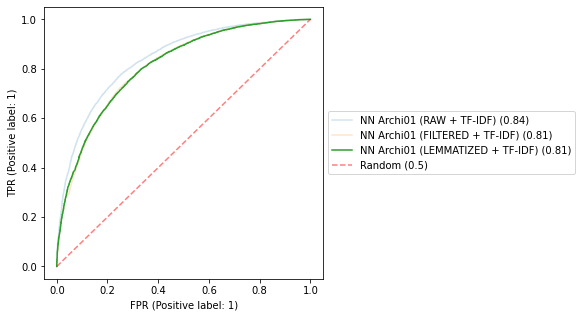

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



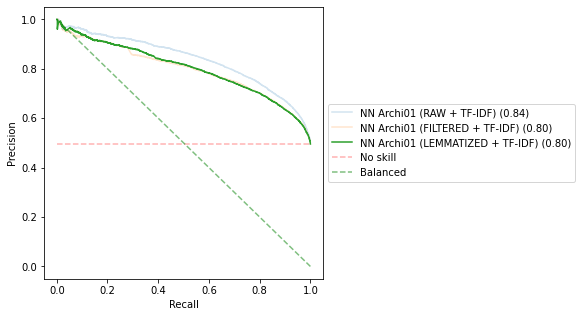

In [45]:
model_name = "NN Archi01 (LEMMATIZED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.4 Comparaison des `scores` avec les différents pré-traitements <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [46]:
from classification_utils import scores_df

In [47]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.840842,0.837456,0.763949,0.76140,0.758994,0.768970,7722,7506,2452,2320,6702.198889,2.064291
1,NN Archi01 (FILTERED + TF-IDF),None,None,0.810867,0.797766,0.733215,0.73635,0.735411,0.731033,7246,7481,2607,2666,2270.121769,2.140008
2,NN Archi01 (LEMMATIZED + TF-IDF),None,None,0.810746,0.800828,0.724244,0.73180,0.738365,0.710654,7044,7592,2496,2868,1410.341004,2.302271


>#### Conclusion de la sélection du pré-traitement:
> - Le jeu de données RAW qui a juste été tokenisé *(split)* donne les meilleurs scores, mais prend beaucoup de temps à entrainer.
> - Les jeux de données FILTERED & LEMMATIZED ont des scores sensiblement équivalents, mais nettement inférieur à ceux du RAW.
> - Le jeu de données LEMMATIZED est le plus rapide à entrainer.
>
> A ce stade, si l'on veut augmenter nos scores il convient d'utiliser le jeu de données RAW.

---
---
# 3. Recherche du `plongement` le plus adapté <a class="anchor" id="EMBEDDING"></a> [⇪](#menu)

> https://fr.wikipedia.org/wiki/Word_embedding
>
> Pour utiliser les données en apprentissage machine, il est nécessaire de leur trouver une représentation mathématique, typiquement des vecteurs. Certaines données s'y prêtent directement, comme par exemple les images, qui engendrent des vecteurs riches en information, encodant toutes les nuances et les couleurs qui les composent. Les mots, quant à eux, sont des éléments d'information isolés, et certaines représentations rudimentaires se limitent à un simple identifiant par mot. Par exemple le mot « chat » sera encodé par un seul identifiant arbitraire, disons X87. C'est une représentation discrète, relativement pauvre, qui ne permet notamment pas de comparer deux mots entre eux5. Les plongements lexicaux, eux, représentent un mot par un vecteur. Par exemple, un chat sera représenté par le vecteur [0,43 0,88 0,98 1,3]. Si l'on encode tous les mots d'un dictionnaire ainsi, il devient alors **possible de comparer les vecteurs des mots entre eux**, par exemple en mesurant l'angle entre les vecteurs. Une bonne représentation de mots permettra alors de trouver que le mot « chien » est plus près du mot « chat » qu'il ne l'est du mot « gratte-ciel »6. Qui plus est, ces représentations permettent d'espérer que, dans l'espace vectoriel où le plongement est fait, on aura l'équation roi - homme + femme = reine ou encore l'équation Paris - France + Pologne = Varsovie7.
> 
> Les plongements lexicaux sont également très **utiles pour mitiger le fléau de la dimension**, un problème récurrent en intelligence artificielle. Sans les plongements de mots, **les identifiants uniques représentant les mots engendrent des données éparses**, des points isolés dans un espace vaste et presque vide6. Avec les plongements de mots, en revanche, l'espace devient beaucoup plus restreint et il est plus facile pour un ordinateur d'y établir des regroupements, d'y découvrir des régularités, en apprentissage machine. 

### Chargeons le jeu de données sélectionné à l'étape précédente

In [122]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [123]:
# sample_size = 100000
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [124]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1303215,"[@RichGolisch, Thanks!]",1
1121114,"[Trying, to, get, a, babysitter, and, be, 999,...",1


(100000, 2)

In [125]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_raw'], data_nlp.target, test_size=0.2, random_state=random_seed)

---
## 3.1 Word2Vec <a class="anchor" id="EMBEDDING_Word2Vec"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [177]:
from gensim.models import Word2Vec

In [178]:
w2v_model = Word2Vec(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [179]:
pretrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

Embedding shape: (12799, 256)


#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [180]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in w2v_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

           good -> great (0.60), nice (0.48), wonderful (0.44), bad (0.42), fantastic (0.42), Good (0.42), fun (0.41), rough (0.39)
            bad -> good (0.42), sad (0.35), bad, (0.35), good. (0.34), bad! (0.33), bad. (0.33), good, (0.33), badly (0.33)
            sad -> upset (0.45), sad. (0.45), sad! (0.43), sad, (0.42), bummed (0.40), depressed (0.37), excited (0.36), sad... (0.36)
       fabulous -> great (0.42), good (0.36), brilliant (0.34), wonderful (0.34), GREAT (0.33), yummy. (0.32), awesome (0.32), fantastic (0.32)
      difficult -> clumsy (0.31), confusing (0.30), dangerous (0.29), important (0.28), hard (0.28), hot. (0.26), Note (0.26), slow... (0.26)
           easy -> easier (0.31), hard (0.30), nice (0.28), hard. (0.27), important (0.27), obvious (0.26), expensive (0.26), worth (0.26)
         boring -> dull (0.34), good (0.30), slow (0.30), bored (0.30), easier (0.29), interesting (0.27), gorgeous (0.27), funny (0.27)
            fun -> fun. (0.49), fun! (0.43), go

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [181]:
def word_embedding_transform(embedding_model, sentences, max_len=65):

    print('\nPreparing the data for Keras NN...')
    train_x = np.zeros([len(sentences), max_len], dtype=np.int32)
    for i, (id,sentence) in enumerate(sentences.iteritems()):
        for t, word in enumerate(sentence[:-1]):
            if word in embedding_model.wv.key_to_index:
                train_x[i, t] = embedding_model.wv.key_to_index[word]
                
    return train_x

In [182]:
X_train_ready = word_embedding_transform(w2v_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(w2v_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)


Preparing the data for Keras NN...
X_train_ready shape: (80000, 65) y_train shape: (80000,)

Preparing the data for Keras NN...
X_test_ready shape: (20000, 65) y_test shape: (20000,)


#### Ajoutons une fonction permettant de convertir notre embedding word2vec en layer tensorflow/keras

In [183]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

### Entrainons notre Neural Network 

In [184]:
embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=True)

In [185]:
archi01_model_RAW_Word2Vec = architecture1(f_opti, f_loss, f_metrics, embedding)

In [186]:
archi01_model_RAW_Word2Vec.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 256)         3276544   
                                                                 
 dropout_16 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_16 (Conv1D)          (None, None, 128)         229504    
                                                                 
 conv1d_17 (Conv1D)          (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [187]:
t0 = time.perf_counter()
history_clf_archi01_RAW_Word2Vec = archi01_model_RAW_Word2Vec.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW_Word2Vec")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2499/2500 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.5724
Epoch 1: val_accuracy improved from -inf to 0.67240, saving model to models/archi01_RAW_Word2Vec.epoch01-accuracy0.67.hdf5
2500/2500 [==============================] - 96s 38ms/step - loss: 0.6758 - accuracy: 0.5724 - val_loss: 0.6176 - val_accuracy: 0.6724 - lr: 5.0000e-05
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6646
Epoch 2: val_accuracy improved from 0.67240 to 0.69735, saving model to models/archi01_RAW_Word2Vec.epoch02-accuracy0.70.hdf5
2500/2500 [==============================] - 98s 39ms/step - loss: 0.6147 - accuracy: 0.6646 - val_loss: 0.5778 - val_accuracy: 0.6974 - lr: 5.0000e-05
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.6864
Epoch 3: val_accuracy improved from 0.69735 to 0.70780, saving model to models/archi01_RAW_Word2Vec.epoch03-accuracy0.71.hdf5
2500/2500 [================

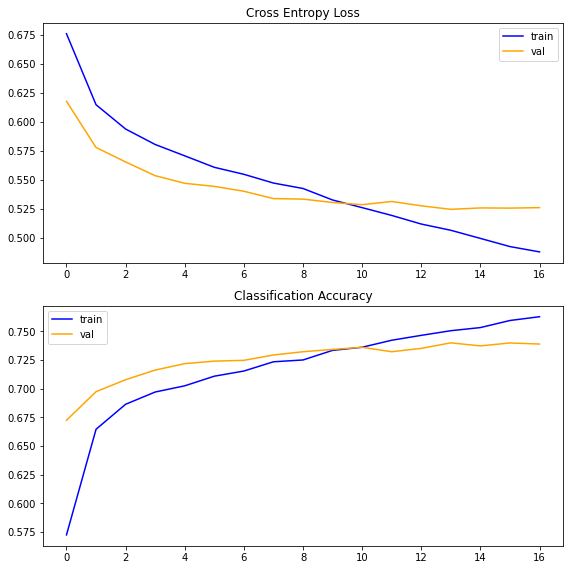

In [188]:
summarize_diagnostics(history_clf_archi01_RAW_Word2Vec)

### Affichons les scores du modèle

In [215]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_Word2Vec.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

625/625 [==============================] - 3s 4ms/step


(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + Word2Vec) --------------------------------------------------------------------

             ROC_AUC : 0.8139
                  F1 : 0.7412
            ACCURACY : 0.7360
           PRECISION : 0.7300
              RECALL : 0.7526
   AVERAGE_PRECISION : 0.8109

       TRAINING-TIME : 2057.8724
      INFERENCE-TIME : 2.8760

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.72      0.73      9958
Prediction = 1       0.73      0.75      0.74     10042

      accuracy                           0.74     20000
     macro avg     

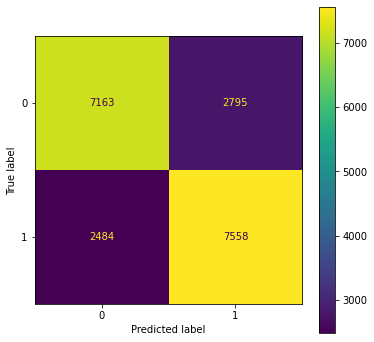

--- ROC AUC ---------------------------------------------------------------------------------------- 



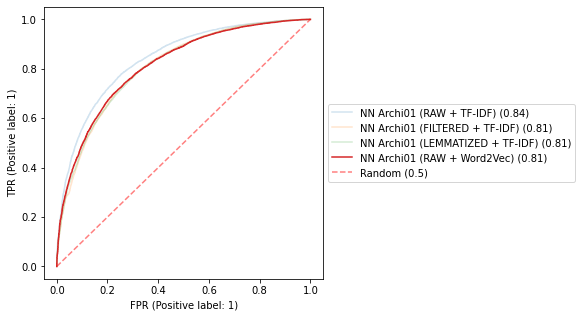

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



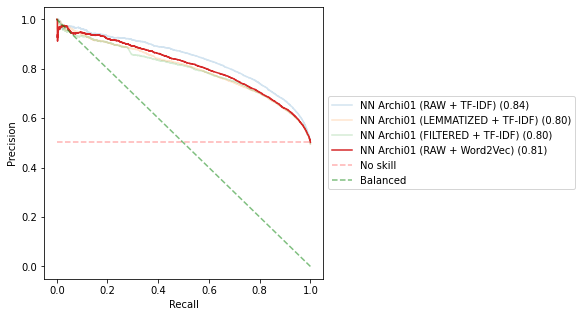

In [216]:
model_name = "NN Archi01 (RAW + Word2Vec)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.2 FastText <a class="anchor" id="EMBEDDING_FastText"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [145]:
from gensim.models import FastText

In [146]:
ft_model = FastText(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [147]:
pretrained_weights = ft_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

Embedding shape: (12799, 256)


#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [148]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in ft_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in ft_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

           good -> goood (0.69), great (0.63), good? (0.62), gooood (0.61), good! (0.58), good. (0.58), good!! (0.58), good.. (0.57)
            bad -> bad? (0.73), bad! (0.70), bad...I (0.67), bad. (0.66), bad, (0.64), badge (0.64), bad... (0.63), badass (0.60)
            sad -> sad! (0.74), sad? (0.73), saddd (0.72), sad, (0.71), sad. (0.66), sad.. (0.65), sad... (0.63), saddened (0.58)
       fabulous -> fabulous. (0.87), great (0.54), fab (0.49), ridiculous (0.48), greatly (0.46), good (0.45), Jealous (0.45), great!! (0.43)
      difficult -> difficult. (0.93), diff (0.55), adult (0.37), hard (0.35), difference. (0.34), default (0.34), hardcore (0.33), harsh (0.33)
           easy -> queasy (0.77), easy. (0.76), greasy (0.63), Easy (0.55), easily (0.53), easier (0.52), easier. (0.47), ease (0.46)
         boring -> boring! (0.84), borin (0.80), boring. (0.80), Boring (0.78), snoring (0.74), exploring (0.67), ignoring (0.57), tiring (0.56)
            fun -> fun? (0.70), fund (0.69

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [191]:
X_train_ready = word_embedding_transform(ft_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(ft_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)


Preparing the data for Keras NN...
X_train_ready shape: (80000, 65) y_train shape: (80000,)

Preparing the data for Keras NN...
X_test_ready shape: (20000, 65) y_test shape: (20000,)


### Entrainons notre Neural Network 

In [192]:
embedding = gensim_to_keras_embedding(ft_model, train_embeddings=True)

In [193]:
archi01_model_RAW_FastText = architecture1(f_opti, f_loss, f_metrics, embedding)

In [194]:
archi01_model_RAW_FastText.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 256)         3276544   
                                                                 
 dropout_18 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_18 (Conv1D)          (None, None, 128)         229504    
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [195]:
t0 = time.perf_counter()
history_clf_archi01_RAW_FastText = archi01_model_RAW_FastText.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW_FastText")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2499/2500 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5511
Epoch 1: val_accuracy improved from -inf to 0.61895, saving model to models/archi01_RAW_FastText.epoch01-accuracy0.62.hdf5
2500/2500 [==============================] - 96s 38ms/step - loss: 0.6935 - accuracy: 0.5512 - val_loss: 0.6574 - val_accuracy: 0.6190 - lr: 5.0000e-05
Epoch 2/50
2500/2500 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.6212
Epoch 2: val_accuracy improved from 0.61895 to 0.64840, saving model to models/archi01_RAW_FastText.epoch02-accuracy0.65.hdf5
2500/2500 [==============================] - 96s 38ms/step - loss: 0.6512 - accuracy: 0.6212 - val_loss: 0.6245 - val_accuracy: 0.6484 - lr: 5.0000e-05
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.6289 - accuracy: 0.6503
Epoch 3: val_accuracy improved from 0.64840 to 0.67510, saving model to models/archi01_RAW_FastText.epoch03-accuracy0.68.hdf5
2500/2500 [================

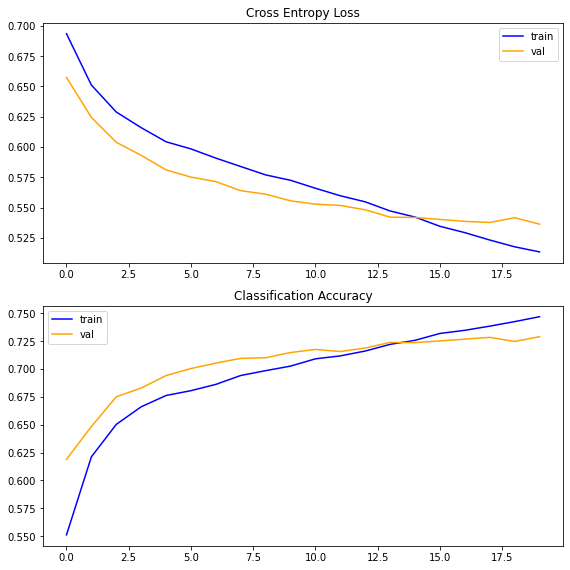

In [196]:
summarize_diagnostics(history_clf_archi01_RAW_FastText)

### Affichons les scores du modèle

In [217]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_FastText.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

625/625 [==============================] - 3s 4ms/step


(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + FastText) --------------------------------------------------------------------

             ROC_AUC : 0.8008
                  F1 : 0.7285
            ACCURACY : 0.7239
           PRECISION : 0.7195
              RECALL : 0.7377
   AVERAGE_PRECISION : 0.7981

       TRAINING-TIME : 2057.8724
      INFERENCE-TIME : 2.8338

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.73      0.71      0.72      9958
Prediction = 1       0.72      0.74      0.73     10042

      accuracy                           0.72     20000
     macro avg     

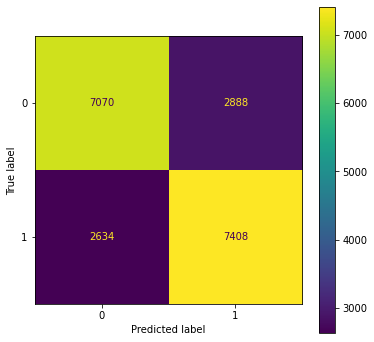

--- ROC AUC ---------------------------------------------------------------------------------------- 



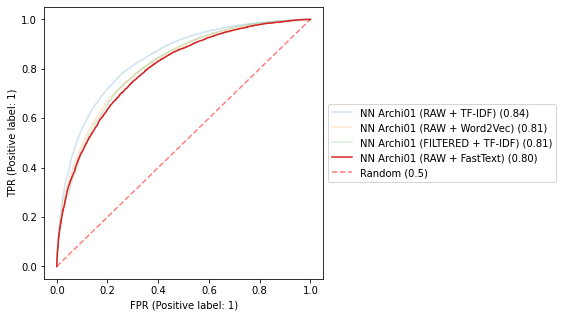

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



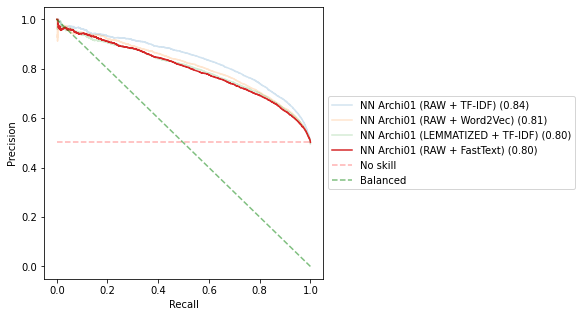

In [218]:
model_name = "NN Archi01 (RAW + FastText)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.3 Comparaison des `scores` avec les différents plongements <a class="anchor" id="EMBEDDING_scores"></a> [⇪](#menu)

In [199]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.840842,0.837456,0.763949,0.76140,0.758994,0.768970,7722,7506,2452,2320,6702.198889,2.064291
1,NN Archi01 (FILTERED + TF-IDF),None,None,0.810867,0.797766,0.733215,0.73635,0.735411,0.731033,7246,7481,2607,2666,2270.121769,2.140008
2,NN Archi01 (LEMMATIZED + TF-IDF),None,None,0.810746,0.800828,0.724244,0.73180,0.738365,0.710654,7044,7592,2496,2868,1410.341004,2.302271
3,NN Archi01 (RAW + Word2Vec),None,None,0.813931,0.810902,0.741162,0.73605,0.730030,0.752639,7558,7163,2795,2484,1746.729847,2.915345
4,NN Archi01 (RAW + FastText),None,None,0.800845,0.798114,0.728489,0.72390,0.719503,0.737702,7408,7070,2888,2634,2057.872424,3.526771


>#### Conclusion de la sélection du plongement:
> TODO